# 1 - Flat Field: Tree Ring Singal

Author: Johnny Esteves, University Of Michigan

### Description
In this notebook, you'll measure the tree ring singal on super flat field images for the R02 S02 (ITL) and R22 S11 (e2v) sensors.



In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import fitsio as fits

import matplotlib.pyplot as plt
plt.rc('image', interpolation='bicubic', origin='lower', cmap = 'viridis')
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['figure.figsize'] = [14.0, 10.0]
plt.rcParams['font.size'] = 16
rcParams = plt.rcParams.copy()

# Load Data


### Super Flat Files

In [2]:
## 10 superflat images

path= '/gpfs/slac/lsst/fs2/u1/devel/arasmus/to_johnny/output/'
itl = 'R02_S02_RTM-013_acqid_10984_R02_S02_H_median.fits'
etv = 'R22_S11_RTM-024_acqid_11351_R22_S11_H_median.fits'

In [3]:
path= '/gpfs/slac/lsst/fs2/u1/devel/arasmus/to_johnny/output/'
itl2= 'R02_S02_R02_S02_H_median.fits'
etv2= 'R22_S11_R22_S11_H_median.fits'

## Super Flats from the RTM-013/024

In [4]:
import numpy as np
import lsst.eotest.image_utils as imutils
import lsst.afw.image as afwImage
from lsst.eotest.sensor.MaskedCCD import MaskedCCD
from lsst.eotest.sensor.AmplifierGeometry import parse_geom_kwd

def make_ccd_mosaic(infile, bias_frame=None, gains=None, fit_order=1,dm_view=False):
    """Combine amplifier image arrays into a single mosaic CCD image array."""
    ccd = MaskedCCD(infile, bias_frame=bias_frame)
    datasec = parse_geom_kwd(ccd.amp_geom[1]['DATASEC'])
    nx_segments = 8
    ny_segments = 2
    nx = nx_segments*(datasec['xmax'] - datasec['xmin'] + 1)
    ny = ny_segments*(datasec['ymax'] - datasec['ymin'] + 1)
    mosaic = np.zeros((ny, nx), dtype=np.float32) # this array has [0,0] in the upper right corner on LCA-13381 view o
     
    for ypos in range(ny_segments):
        for xpos in range(nx_segments):
            amp = ypos*nx_segments + xpos + 1      
            detsec = parse_geom_kwd(ccd.amp_geom[amp]['DETSEC'])
            xmin = nx - max(detsec['xmin'], detsec['xmax'])
            xmax = nx - min(detsec['xmin'], detsec['xmax']) + 1
            ymin = ny - max(detsec['ymin'], detsec['ymax'])
            ymax = ny - min(detsec['ymin'], detsec['ymax']) + 1
            #
            # Extract bias-subtracted image for this segment - overscan not corrected, since we don't pass overscan he
            #
            segment_image = ccd.unbiased_and_trimmed_image(amp, fit_order=fit_order)
            subarr = segment_image.getImage().getArray()
            #
            # Determine flips in x- and y- direction
            #
            if detsec['xmax'] > detsec['xmin']: # flip in x-direction
              subarr = subarr[:, ::-1]
            if detsec['ymax'] > detsec['ymin']: # flip in y-direction
              subarr = subarr[::-1, :]
            #
            # Convert from ADU to e-
            #
            if gains is not None:
              subarr *= gains[amp]
            #
            # Set sub-array to the mosaiced image
            #
            mosaic[ymin:ymax, xmin:xmax] = subarr  
    if dm_view:
      # transpose and rotate by -90 to get a mosaic ndarray that will look like the LCA-13381 view with matplotlib(origin='lower') rotated CW by 90 for DM view
      mosaicprime = np.zeros((ny, nx), dtype=np.float32) 
      mosaicprime[:,:] = np.rot90(np.transpose(mosaic),k=-1)    
      image = afwImage.ImageF(mosaicprime)  
    else:
      # transpose and rotate by 180 to get a mosaic ndarray that will look like the LCA-13381 view with matplotlib(origin='lower')
      mosaicprime = np.zeros((nx, ny), dtype=np.float32) 
      mosaicprime[:,:] = np.rot90(np.transpose(mosaic),k=2)    
      image = afwImage.ImageF(mosaicprime)  
    
    return image
      

In [5]:
# itl = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/ITL-3800C-%i_median_sflat.fits' 
# itl2= '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/ITL-3800C-%i_dark_pixel_mask.fits' 
# itl = itl%(205)
# itl2= itl2%(205)

# image = np.rot90(make_ccd_mosaic(itl).getArray())
# mask  = np.rot90(make_ccd_mosaic(itl2).getArray())
# image[mask>0] = 0.

# etv = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-024/11318/dark_defects_raft/v0/88033/E2V-CCD250-%i_median_sflat.fits' 
# etv2= '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-024/11318/dark_defects_raft/v0/88033/E2V-CCD250-%i_dark_pixel_mask.fits' 
# etv = etv%(382)
# etv2= etv2%(382)

# image = image-np.median(image)

In [36]:
from astropy.io import fits
def get_fits(fname):
    hdulist = fits.open(fname)
    image = hdulist[1].data
    return image,hdulist

def load_image(fname,sensor='itl',overwrite=False):
    if (os.path.isfile('tmp/%s_flat.fits'%(sensor))) & (not overwrite):
        fname = 'tmp/%s_flat.fits'%(sensor)
        print('tmp: found flat field')
        print(fname)
        image, hdulist = get_fits(fname)
    else:
        image, hdulist = get_fits(fname)
        image = image#-np.median(image)
        ## save the file locally
        hdulist[1].data = image
        hdulist.writeto('tmp/%s_flat.fits'%sensor,overwrite=True)
    return image, hdulist

# ITL Tree Ring Signal

In [37]:
image, hdu = load_image(path+itl2,sensor='itl',overwrite=False)

## row flipped
image = np.flip(image,0)

tmp: found flat field
tmp/itl_flat.fits


In [38]:
## Checking image shape: (4000, 4072)

image.shape

(4000, 4072)

In [39]:
diff, _ = get_fits('tmp/%s_flat_diff.fits'%'itl')


### Tree Ring Analysis

In [40]:
from tree_ring_helper import *

In [41]:
ring_itl = tree_ring_tools(sensor='ITL',loc=0)

ring_itl.img_cut = 100.*(image-np.median(image))
ring_itl.img     = 100.*(image-np.median(image))
ring_itl.diff    = 100.*diff

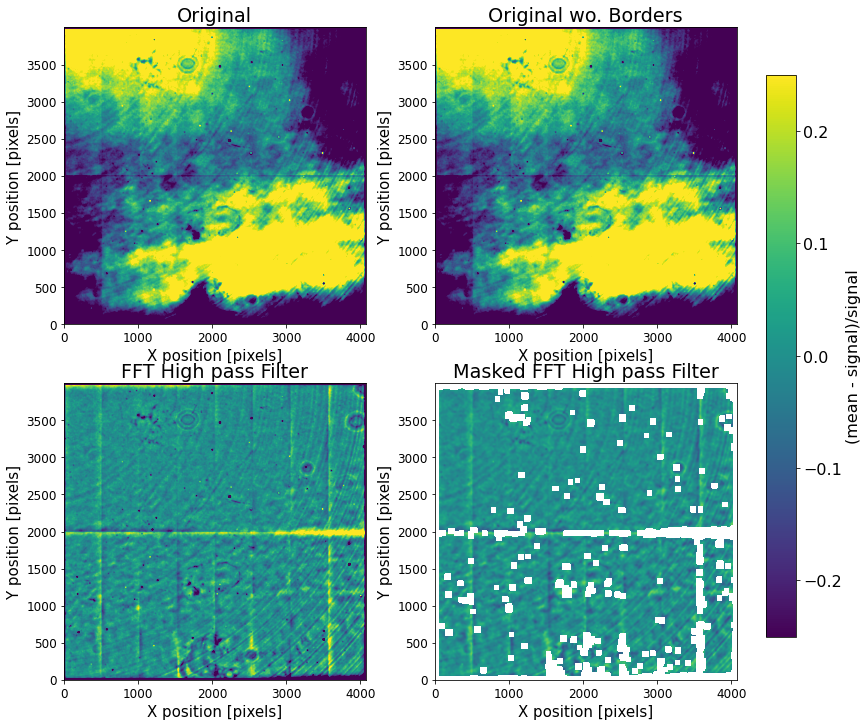

In [42]:
## always run in the following order
# ring_itl.apply_high_freq_filter()
ring_itl.apply_gaussian_filter(downscale=8)
ring_itl.apply_mask(downscale=8,threshold=0.175)

ring_itl.set_ylabel(r'(mean - signal)/signal')
ring_itl.set_levels([-0.25,0.25])
ring_itl.display_images()

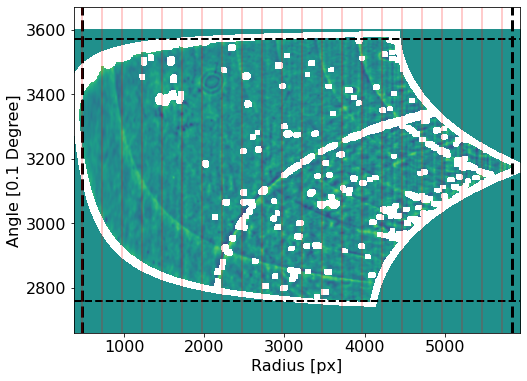

In [43]:
ring_itl.make_polar_transformation(rborder=70.)
ring_itl.check_polar_transfomartion()

(3100.0, 5376.0)

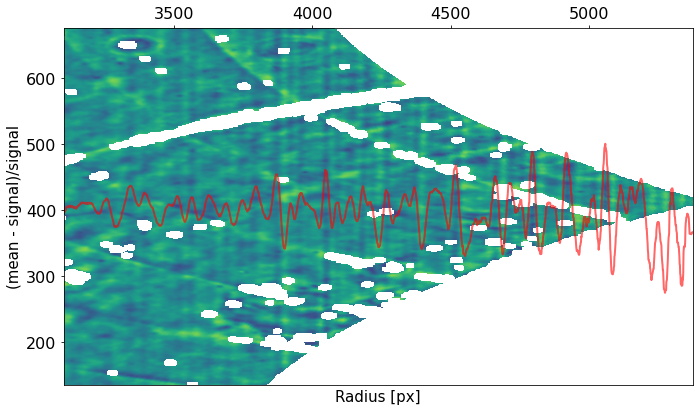

In [44]:
ring_itl.compute_signal(zeroNan=True)
ring_itl.plot_superposition_polar_signal()
plt.xlim(3100,)

In [45]:
ring_itl.save_profile('flat_norm')

saving: profiles/polar_ITL_flat_norm.npy


(-0.2, 0.2)

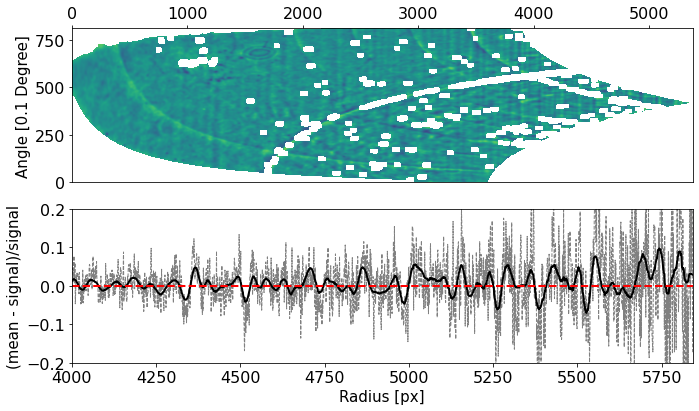

In [46]:
ring_itl.plot_pannel_image_signal()
plt.xlim(4000,)
plt.ylim(-0.2,0.2)

# E2V Tree Ring Signal

In [17]:
from astropy.io import fits
image, hdu = load_image(path+etv2,sensor='etv',overwrite=False)

## row flipped
image = np.flip(image,0)

tmp: found flat field
tmp/etv_flat.fits


In [18]:
## Checking image shape: (4000, 4072)

image.shape

(4004, 4096)

In [19]:
diff, _ = get_fits('tmp/%s_flat_diff.fits'%'e2v')

### Tree Ring Analysis

In [20]:
from tree_ring_helper import *

In [21]:
ring_e2v = tree_ring_tools(sensor='e2v',loc=3)

ring_e2v.img_cut = 100.*(image-np.median(image))
ring_e2v.img     = 100.*(image-np.median(image))
ring_e2v.diff    = 100.*diff

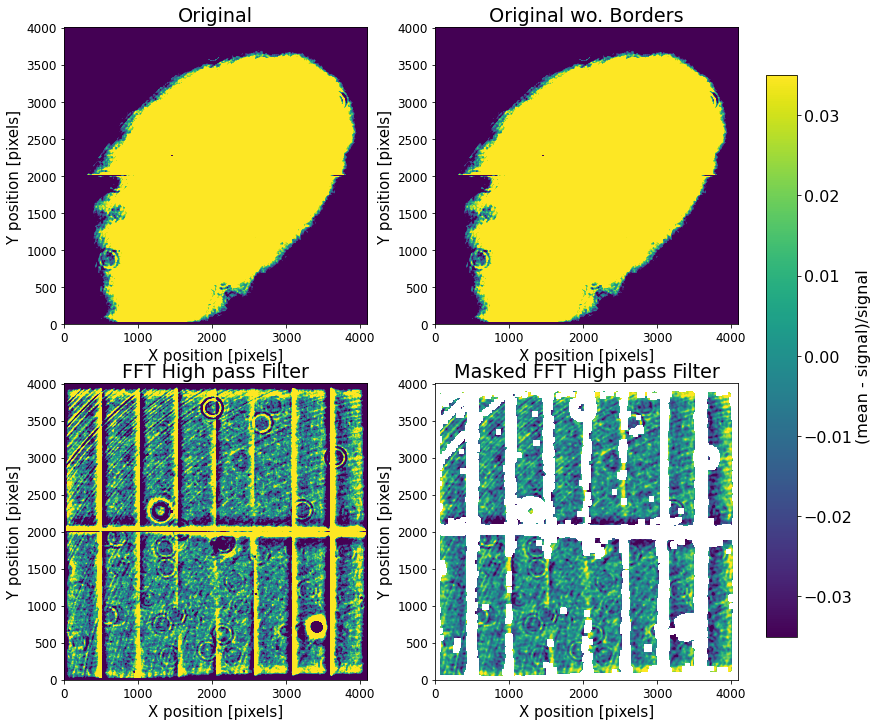

In [28]:
## always run in the following order
# ring_e2v.apply_high_freq_filter()
ring_e2v.apply_gaussian_filter(downscale=8)
ring_e2v.apply_mask(downscale=8,threshold=0.065)

ring_e2v.set_ylabel(r'(mean - signal)/signal')
ring_e2v.set_levels([-0.035,0.035])
ring_e2v.display_images()

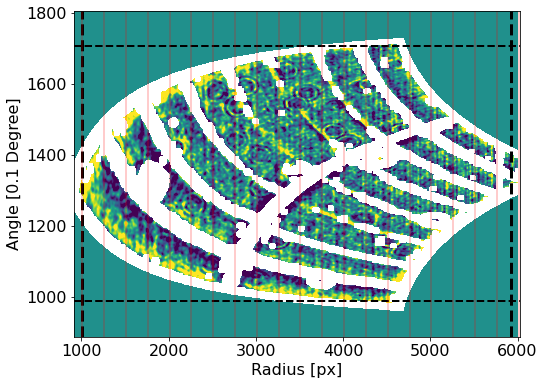

In [29]:
ring_e2v.set_levels([-0.025,0.025])
ring_e2v.make_polar_transformation(rborder=70.)
ring_e2v.check_polar_transfomartion()

(3100.0, 4918.0)

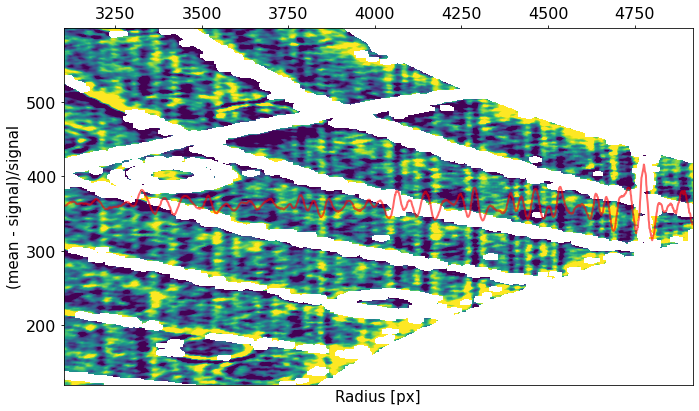

In [30]:
ring_e2v.compute_signal(zeroNan=True)
ring_e2v.plot_superposition_polar_signal()
plt.xlim(3100,)

In [31]:
ring_e2v.save_profile('flat_norm')

saving: profiles/polar_e2v_flat_norm.npy


(-0.075, 0.075)

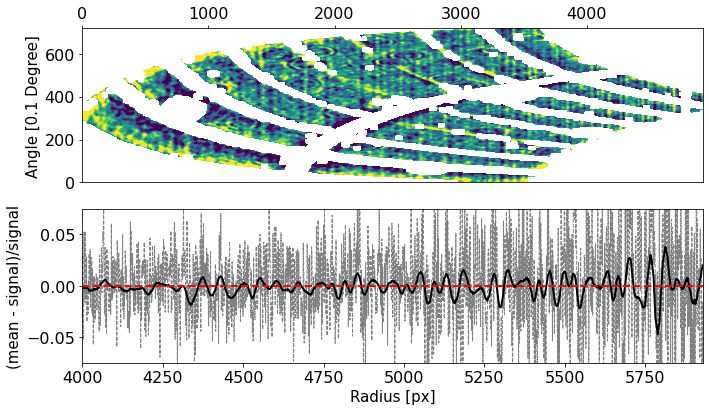

In [32]:
ring_e2v.plot_pannel_image_signal()
plt.xlim(4000,)
plt.ylim(-0.075,0.075)